# Diffusion Transformers 

> we will train a DiT on MNIST conditioning on label.

> we will not do LDM in this case as the image is already in (32x32) which is usually the space in which DiTs function.


In this blog we will understand the architecture of the DiT which in many ways is very similar to ViT


[original paper](https://arxiv.org/pdf/2212.09748)  
[original code](https://github.com/facebookresearch/DiT/blob/main/models.py)

In [2]:
# Looad required libraries 

import torch 
import fastcore.all as fc
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [3]:
# Now say we have MNIST data in the shape of (N, 1, 28, 28)
# we will create a VAE model to generate new images similar to the training data. 

# Load MNIST data 

# Load MNIST data and resize it to 64x64
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor(),
                                ])),
    batch_size=64, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor(),
                                ])),
    batch_size=64, shuffle=False)

len(train_loader), len(val_loader)

(938, 157)

In [4]:
imgs, labels = next(iter(train_loader))
imgs.shape, labels.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64]))

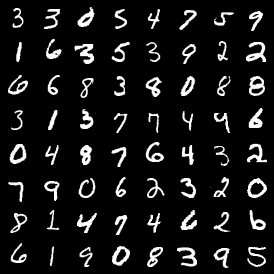

In [5]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(imgs, nrow=8, normalize=False))

## Patchify
32x32x1 image is patched using p=2, 4, 8 in the paper. so for example if we take 4. each patch is of size 4x4x1, we will ouput a `N_emb` vector for each patch. so that output of the layer will be (32x32x1)/(4x4x1) (64, N_emb). lets use 128 as `N_emb` here as we are learning MNIST digits here. In original paper they start with 768 for the base model and increase from der.

the easiest way to patch is use conv layer with kernel size and stride as patch_size. 

In [6]:
class Patchify(torch.nn.Module):
    def __init__(self, ims, ps, in_chans, embed_dim):
        super().__init__()
        self.total_patches = (ims/ps)**2
        self.proj = torch.nn.Conv2d(in_chans, embed_dim, kernel_size=ps, stride=ps, bias=True)
    
    def forward(self, x):
        B, C, H, W = x.shape
        out = self.proj(x)
        out = out.flatten(2).transpose(1, 2)
        return out
patch = Patchify(32, 4, 1, 128)
patch.total_patches

64.0

In [7]:
tokens = patch(imgs)
tokens.shape

torch.Size([64, 64, 128])

## Positional embedding 

we can add sin-cos embeddings are making this layer learnable. in the original paper this is learnable

In [8]:
pos_embed = torch.nn.Parameter(torch.zeros(1, int(patch.total_patches), 128))
tokens = tokens + pos_embed
tokens.shape

torch.Size([64, 64, 128])

In this model we have have to condition on label (or text or another image) and time.There are three ways we can add conditioning to the model. 
- prepend to the tokens and process them similar to [cls] token
- cross attention
- Adapative layer norm (AdaLN) block (used in stylegan originally)

we will see each of these and use one of it. In the papers authors used AdaLN as it adds the least Gflops and is the most compute efficient. 

before that, lets get label and time embeddings

## Label embedding
we have 10 labels + 1 null label (for classifier guidance) in this model.

In [9]:
class LabelEmbedding(torch.nn.Module):
    def __init__(self, num_classes, embed_dim, drop_out_prob=0.1):
        super().__init__()
        fc.store_attr()
        self.cfg_guide = drop_out_prob > 0
        self.embedding = torch.nn.Embedding(num_classes+self.cfg_guide, embed_dim)
    
    def forward(self, labels, train=True):
        if train and self.drop_out_prob > 0:
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.drop_out_prob
            labels = torch.where(drop_ids, self.num_classes, labels)
        return self.embedding(labels)

le = LabelEmbedding(10, 128, 0.1)
le(labels)
label_emb = le(labels, train=True)
label_emb.shape

torch.Size([64, 128])

## Time embedding
I m not going deep into this but think of this as taking t as input and giving out a 128 dim vector. 

#TODO: I will add the intution  behind this later with mathematical roots for doing this.

copying the original function here.

In [10]:
class TimestepEmbedder(torch.nn.Module):
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -torch.log(torch.tensor(max_period)) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb

In [11]:
# while training diffusion models, we use different timestep for each image
timesteps = torch.randint(0, 1000, (64,))
timestep_embedder = TimestepEmbedder(128)
timestep_embedder(timesteps)
te = timestep_embedder(timesteps)
te.shape

torch.Size([64, 128])

In [12]:
conditioning_tokens = te+label_emb
conditioning_tokens.shape

torch.Size([64, 128])

## Transformer block 

There are two different ways in which we can use attentions. 
- self-attention: in paper this is referred as `in-context` learning. we will prepend conditioning token to the original tokens and pass through transformer blocks
- cross-attention: in attn, k, v comes from conditioning and q comes from tokens. attention is calculated againt these and hence cross attention.

we will implement both of them below

In [13]:
transformer_inputs = torch.cat([conditioning_tokens.unsqueeze(1), tokens], dim=1)
transformer_inputs.shape

torch.Size([64, 65, 128])

In [30]:
class MHSA(torch.nn.Module):
    def __init__(self, dim, num_heads, dropout=0.0):
        super().__init__()
        assert dim % num_heads == 0, "dim must be divisible by num_heads"
        self.dim, self.num_heads, self.head_dim = dim, num_heads, dim // num_heads
        self.qkv_proj = torch.nn.Linear(dim, 3 * dim)
        self.output_proj = torch.nn.Linear(dim, dim)
        self.dropout_p = dropout

    def forward(self, x, mask=None):
        b, l, _ = x.shape
        qkv = self.qkv_proj(x).reshape(b, l, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None if mask is None else mask.squeeze(1), dropout_p=self.dropout_p if self.training else 0.0, is_causal=mask is None)
        return self.output_proj(attn.permute(0, 2, 1, 3).flatten(2))

mhsa = MHSA(128, 8)
mhsa(transformer_inputs).shape

torch.Size([64, 65, 128])

## Cross attention 

In [39]:
class MHCA(torch.nn.Module):
    def __init__(self, dim, num_heads, dropout=0.0):
        super().__init__()
        assert dim % num_heads == 0, "dim must be divisible by num_heads"
        self.dim, self.num_heads, self.head_dim = dim, num_heads, dim // num_heads
        self.scale = 1.0 / torch.sqrt(torch.tensor(self.head_dim))
        self.q_proj, self.kv_proj = torch.nn.Linear(dim, dim), torch.nn.Linear(dim, 2 * dim)
        self.output_proj = torch.nn.Linear(dim, dim)
        self.dropout_p = dropout
        
    def forward(self, x, context, mask=None):
        b, l, l_ctx = x.shape[0], x.shape[1], context.shape[1]
        q = self.q_proj(x).reshape(b, l, self.num_heads, self.head_dim).transpose(1, 2)
        kv = self.kv_proj(context).reshape(b, l_ctx, 2, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]
        attn_output = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=mask, dropout_p=self.dropout_p if self.training else 0.0)
        return self.output_proj(attn_output.transpose(1, 2).reshape(b, l, self.dim))
    
mhca = MHCA(128, 8)
mhca(tokens, conditioning_tokens.unsqueeze(1)).shape

torch.Size([64, 64, 128])

## Adaptive layer norm (adaLN) block
In the papers, authors use the following block 

<img src="images/dit1.png" width="500" />

so we will use `MHSA` attn as implemented above. 

- The adaLN module outputs $\gamma_{1}$, $\beta_{1}$  and  $\gamma_{2}$, $\beta_{2}$ (scale and shift applied to layernorm outputs). we can see in the above picture how they are applied 
- The  $\alpha_{1}$ and $\alpha_{2}$  is scale applied prior to any residual connections within the DiT block. we zero initalize them so that the entire block works like an identity function first. 

in the original code this is not clear, so we will modify accordingly.

In [53]:
class Mlp(torch.nn.Module):
    def __init__(self, in_features, hidden_features=None, act_layer=torch.nn.GELU, drop=0.):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.drop = torch.nn.Dropout(drop)
        self.fc2 = torch.nn.Linear(hidden_features, in_features)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    
def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

class DiTBlock(torch.nn.Module):
    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0, **block_kwargs):
        super().__init__()
        self.norm1 = torch.nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = MHSA(hidden_size, num_heads=num_heads, **block_kwargs)
        self.norm2 = torch.nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        approx_gelu = lambda: torch.nn.GELU(approximate="tanh")
        self.mlp = Mlp(in_features=hidden_size, hidden_features=mlp_hidden_dim, act_layer=approx_gelu, drop=0)
        self.adaLN_modulation = torch.nn.Sequential(
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_size, 4 * hidden_size, bias=True)
        )
        self.adaLN_zero = torch.nn.Sequential(
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )
        self.__init_weights()
    
    def __init_weights(self):
        torch.nn.init.zeros_(self.adaLN_zero[1].weight)
        torch.nn.init.zeros_(self.adaLN_zero[1].bias)

    def forward(self, x, c):
        alpha1, alpha2 = self.adaLN_zero(c).chunk(2, dim=1)
        scale1, shift1, scale2, shift2 = self.adaLN_modulation(c).chunk(4, dim=1)

        y = self.norm1(x)
        y = modulate(y, shift1, scale1)
        y = self.attn(y)
        x = x + alpha1.unsqueeze(1) * y

        y = self.norm2(y)
        y = modulate(y, shift2, scale2)
        y = self.mlp(y)
        y = x + alpha2.unsqueeze(1) * y
        return x
    
    
db = DiTBlock(128, 8)
out = db(tokens, conditioning_tokens)
print(out.shape)
        

torch.Size([64, 64, 128])


## Transformer Decoder 
After encoding the images and passing through transformer blocks we need to decode them back to image space. We use a standard linear decoder to do this; we apply the final layer norm (adaptive if using adaLN) and linearly decode each token into a p×p×2C tensor, where C is the number of channels in the spatial input to DiT. Finally, we rearrange the decoded tokens into their original spatial layout to get the predicted noise and covariance.


In [57]:
class FinalLayer(torch.nn.Module):
    """
    The final layer of DiT.
    """
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = torch.nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = torch.nn.Linear(hidden_size, patch_size * patch_size * out_channels, bias=True)
        self.adaLN_modulation = torch.nn.Sequential(
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x

In [59]:
output = FinalLayer(128, 4, 1)(out, conditioning_tokens)
output.shape

torch.Size([64, 64, 16])

In [67]:
class DiT(torch.nn.Module):
    def __init__(self, image_size, patch_size, in_chans, num_labels, hidden_size, num_heads, num_layers, mlp_ratio=4.0, **block_kwargs):
        super().__init__()
        fc.store_attr()
        self.patch = Patchify(image_size, patch_size, in_chans, hidden_size)
        self.pos_embed = torch.nn.Parameter(torch.zeros(1, int(self.patch.total_patches), hidden_size))
        self.label_embed = LabelEmbedding(num_labels,  hidden_size, 0.1) #cfg gudience is hardcoded here
        self.timestep_embedder = TimestepEmbedder(hidden_size)
        self.layers = torch.nn.ModuleList([DiTBlock(hidden_size, num_heads, mlp_ratio, **block_kwargs) for _ in range(num_layers)])
        self.final_layer = FinalLayer(hidden_size, patch_size, in_chans)
        self.out_channels = in_chans

    
    def unpatchify(self, x):
        """
        x: (N, T, patch_size**2 * C)
        imgs: (N, H, W, C)
        """
        c = self.out_channels
        p = self.patch_size
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
        return imgs
        
    def forward(self, x, labels, timesteps):
        x = self.patch(x)
        x = x + self.pos_embed
        
        t = self.timestep_embedder(timesteps)
        c = self.label_embed(labels)
        c = c+t 
        for layer in self.layers:
            x = layer(x, c)
        x = self.final_layer(x, c)
        x = self.unpatchify(x)
        return x
        

In [68]:
model = DiT(image_size=32, patch_size=4, in_chans=1, num_labels=10, hidden_size=128, num_heads=8, num_layers=12)
model

DiT(
  (patch): Patchify(
    (proj): Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
  )
  (label_embed): LabelEmbedding(
    (embedding): Embedding(11, 128)
  )
  (timestep_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (layers): ModuleList(
    (0-11): 12 x DiTBlock(
      (norm1): LayerNorm((128,), eps=1e-06, elementwise_affine=False)
      (attn): MHSA(
        (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
        (output_proj): Linear(in_features=128, out_features=128, bias=True)
      )
      (norm2): LayerNorm((128,), eps=1e-06, elementwise_affine=False)
      (mlp): Mlp(
        (fc1): Linear(in_features=128, out_features=512, bias=True)
        (act): GELU(approximate='tanh')
        (drop): Dropout(p=0, inplace=False)
        (fc2): Linear(in_features=512, out_features=128, bias=True)
      )
 

In [65]:
out = model(imgs, labels, timesteps)
out.shape

torch.Size([64, 1, 32, 32])

In [69]:
params = sum(p.numel() for p in model.parameters())
params


3658256

Since the architecture is implemented now we will use it to train on MNIST dataset. 